In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import linear_assignment_ as munkres
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from aye.assignment import *

In [2]:
class OverlapRatioType:
    Union, Min = range(2)

def bbox_intersect(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return (abs(x1 - x2) * 2 < (w1 + w2)) and (abs(y1 - y2) * 2 < (h1 + h2))

def bbox_overlap_ratio(bbox1, bbox2, ratio_type=OverlapRatioType.Union):
    if bbox_intersect(bbox1, bbox2):
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        # intersection area is a * b, where a is width and b is height
        a = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
        b = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        area_intersection = a * b
        area_b1 = w1 * h1
        area_b2 = w2 * h2
        if ratio_type == OverlapRatioType.Union:
            area_union = area_b1 + area_b2 - area_intersection
            overlap_ratio = area_intersection / area_union
        elif ratio_type == OverlapRatioType.Min:
            area_min = min(area_b1, area_b2)
            overlap_ratio = area_intersection / area_min
    else:
        overlap_ratio = 0.0
    
    return overlap_ratio

def bboxes_overlap_ratio(bboxes1, bboxes2, ratio_type=OverlapRatioType.Union):
    n1 = len(bboxes1)
    n2 = len(bboxes2)
    
    R = np.zeros((n1, n2))
    
    for i1, b1 in enumerate(bboxes1):
        for i2, b2 in enumerate(bboxes2):                
            R[i1, i2] = bbox_overlap_ratio(b1, b2)
    return R
    
def bbox_distance_squared(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    cx1 = x1 + w1 / 2.0
    cy1 = y1 + h1 / 2.0
    cx2 = x2 + w2 / 2.0
    cy2 = y2 + h2 / 2.0
    return (cx1 - cx2) ** 2 + (cy1 - cy2) ** 2

def bbox_distance_squared_area_ratio(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    cx1 = x1 + w1 / 2.0
    cy1 = y1 + h1 / 2.0
    cx2 = x2 + w2 / 2.0
    cy2 = y2 + h2 / 2.0
    distance_squared =  (cx1 - cx2) ** 2 + (cy1 - cy2) ** 2
    area = w1 * h1 + w2 * h2
    return distance_squared / area
    
def bboxes_assign_cost(bboxes1, bboxes2):
    n1 = len(bboxes1)
    n2 = len(bboxes2)
    assert n1 > 0 and n2 > 0
    
    C = np.zeros((n1, n2))
    for i1, b1 in enumerate(bboxes1):
        for i2, b2 in enumerate(bboxes2):
            overlap_ratio = bbox_overlap_ratio(b1, b2)
            overlap_cost = 1 - overlap_ratio
            distance_squared_area_cost = bbox_distance_squared_area_ratio(b1, b2)
            C[i1, i2] = overlap_cost  + distance_squared_area_cost
    return C

In [3]:
def plot_bboxes(ax, bboxes, color='blue', alpha=0.5):
    for bbox in bboxes:
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, facecolor=color, alpha=alpha)
        ax.add_patch(rect)

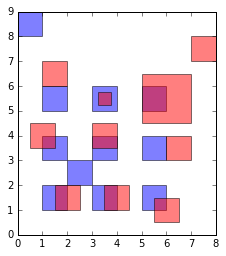

In [4]:
d = 1
bboxes1 = np.array([[d, d, d, d],
                    [d, 3 * d, d, d], 
                    [d, 5 * d, d, d],
                    [3 * d, d, d, d], 
                    [3 * d, 3 * d, d, d],
                    [3 * d, 5 * d, d, d],
                    [5 * d, d, d, d],
                    [5 * d, 3 * d, d ,d],
                    [5 * d, 5 * d, d, d],
                    [2 * d, 2 * d, d, d],
                    [0, 8 * d, d, d]], float)

bboxes2 = np.array([[d * 1.5, d, d, d],
                    [7 * d, 7 * d, d, d],
                    [0.5 * d, 3.5 * d, d, d], 
                    [d, 6 * d, d, d],
                    [3.5 * d, d, d, d],
                    [3 * d, 3.5 * d, d, d],
                    [3.25 * d, 5.25 * d, 0.5 * d, 0.5 * d],
                    [5.5 * d, 0.5 * d, d, d],
                    [6 * d, 3 * d, d, d],
                    [5 * d, 4.5 * d, 2 * d, 2 * d]], float)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plot_bboxes(ax, bboxes1)
plot_bboxes(ax, bboxes2, color='red')

ax.autoscale_view(tight=False)

In [5]:
def pad_cost_matrix(cost_matrix, unassigned_cost):
    if unassigned_cost == 0.0:
        return cost_matrix

    r, c = cost_matrix.shape
    # padded size
    n = r + c
    float_max = np.finfo(np.float).max
    padded_cost_matrix = np.ones((n, n)) * float_max
    # fill in 
    padded_cost_matrix[:r, :c] = cost_matrix
    padded_cost_matrix[r:, c:] = 0.0
    padded_cost_matrix[range(r), range(c, n)] = unassigned_cost
    padded_cost_matrix[range(r, n), range(c)] = unassigned_cost
    return padded_cost_matrix

def hungarian_assignment1(cost_matrix, unassigned_cost=1.5):
    padded_cost_matrix = pad_cost_matrix(cost_matrix, unassigned_cost)
    return munkres.linear_assignment(padded_cost_matrix)

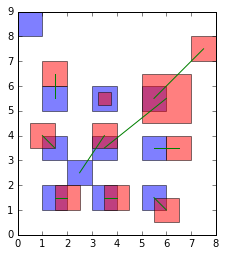

In [6]:
# Test bbox overlap ratio
cost = bboxes_assign_cost(bboxes1, bboxes2)
assignment = munkres.linear_assignment(cost)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plot_bboxes(ax, bboxes1)
plot_bboxes(ax, bboxes2, color='red')
ax.autoscale_view(tight=False)
for pair in assignment:
    i1, i2 = pair
    b1 = bboxes1[i1]
    b2 = bboxes2[i2]
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    ax.plot([x1 + w1 / 2, x2 + w2 / 2], [y1 + h1 / 2, y2 + h2 / 2], c='green')

[ 9 10]
[1]
[[0 0]
 [1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]
 [8 9]]


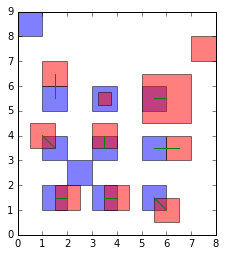

In [7]:
assignment = hungarian_assignment1(cost)
r, c = cost.shape

r_inds = assignment[:, 0]
c_inds = assignment[:, 1]
match_inds = (r_inds < r) & (c_inds < c)
un_bboxes1_ind = (r_inds < r) & (c_inds >= c)
un_bboxes2_ind = (r_inds >= r) & (c_inds < c)
matches = assignment[match_inds]
unassigned_bboxes1 = r_inds[un_bboxes1_ind]
unassigned_bboxes2 = c_inds[un_bboxes2_ind]
print(unassigned_bboxes1)
print(unassigned_bboxes2)


print(matches)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plot_bboxes(ax, bboxes1)
plot_bboxes(ax, bboxes2, color='red')
ax.autoscale_view(tight=False)
for pair in matches:
    i1, i2 = pair
    b1 = bboxes1[i1]
    b2 = bboxes2[i2]
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    ax.plot([x1 + w1 / 2, x2 + w2 / 2], [y1 + h1 / 2, y2 + h2 / 2], c='green')

In [8]:
a, b, c = hungarian_assignment(cost, 1.5)
print(a, b, c)

(array([[0, 0],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6],
       [6, 7],
       [7, 8],
       [8, 9]]), array([ 9, 10]), array([1]))
